Alexander S. Lundervold, v.21.03.23

# Introduction

This notebook will illustrate a simple adversarial attack on a deep learning model: the Fast Gradient Sign Method (FGSM). First, we'll train a model to detect abnormalities in X-rays and then use the FSGM to create adversarial examples and see how the model classifies them.

> The example was used as part of a module in the course [DAT255](https://github.com/HVL-ML/DAT255) at HVL. See the notebook [`dat255-1-0-adversarial-dogs-vs-cats`](https://www.kaggle.com/alexanderlundervold/dat255-1-0-adversarial-dogs-vs-cats) for a more in-depth explanation of the Fast Gradient Sign Attack used below.

# Setup

In [1]:
from fastai.vision.all import *

In [2]:
DATA = Path('/kaggle/input/mura-v11')
DATA.ls()

(#1) [Path('/kaggle/input/mura-v11/MURA-v1.1')]

# Prepare data

In [3]:
train_df = pd.read_csv(DATA/'MURA-v1.1'/'train_image_paths.csv', header=None)
valid_df = pd.read_csv(DATA/'MURA-v1.1'/'valid_image_paths.csv', header=None)

In [4]:
train_df['is_valid'] = False
valid_df['is_valid'] = True

In [5]:
df = pd.concat([train_df, valid_df], axis=0)

In [6]:
df.columns = ["study", "is_valid"]

In [7]:
df.head()

,study,is_valid
0,MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/image1.png,False
1,MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/image2.png,False
2,MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/image3.png,False
3,MURA-v1.1/train/XR_SHOULDER/patient00002/study1_positive/image1.png,False
4,MURA-v1.1/train/XR_SHOULDER/patient00002/study1_positive/image2.png,False


In [8]:
def get_label(fn):
    return fn.split("/")[-2].split("_")[-1]

def get_subject_id(fn):
    return fn.split("/")[-3][7:]

def get_bodypart(fn):
    return fn.split("/")[2]

In [9]:
df['label'] = df["study"].apply(get_label)

In [10]:
df['subject_id'] = df["study"].apply(get_subject_id)

In [11]:
df['bodypart'] = df["study"].apply(get_bodypart)

In [12]:
df.head()

,study,is_valid,label,subject_id,bodypart
0,MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/image1.png,False,positive,00001,XR_SHOULDER
1,MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/image2.png,False,positive,00001,XR_SHOULDER
2,MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/image3.png,False,positive,00001,XR_SHOULDER
3,MURA-v1.1/train/XR_SHOULDER/patient00002/study1_positive/image1.png,False,positive,00002,XR_SHOULDER
4,MURA-v1.1/train/XR_SHOULDER/patient00002/study1_positive/image2.png,False,positive,00002,XR_SHOULDER


In [13]:
df.label.value_counts()

negative    23602
positive    16403
Name: label, dtype: int64

In [14]:
len(df.subject_id.unique())

11967

> **NB:** There are multiple images taken per study, and the label assigned to an image is based on the _study label_. Since abnormalities aren't necessarily visible in every image of a study, this is actually a _multi-view problem_. We will disregard this here and pretend that we have image-level labels. 

## Sample data set

As the below training takes a long time, we'll restrict ourselves to only one class of images

In [15]:
df.bodypart.value_counts()

XR_WRIST       10411
XR_SHOULDER     8942
XR_HAND         6003
XR_FINGER       5567
XR_ELBOW        5396
XR_FOREARM      2126
XR_HUMERUS      1560
Name: bodypart, dtype: int64

In [16]:
bodypart = 'XR_WRIST'

In [17]:
df = df.loc[df.bodypart == bodypart]

In [18]:
df.is_valid.value_counts()

False    9752
True      659
Name: is_valid, dtype: int64

In [19]:
df.label.value_counts()

negative    6129
positive    4282
Name: label, dtype: int64

# Dataloaders

In [20]:
sz=224
item_tfms = Resize(sz)
batch_tfms = None
bs=64

In [21]:
dblock = DataBlock(blocks=(ImageBlock, CategoryBlock), 
                   get_x=ColReader('study', pref=DATA), 
                   get_y=ColReader('label'),
                   splitter=ColSplitter(col='is_valid'), 
                   item_tfms=item_tfms, 
                   batch_tfms=batch_tfms)


In [22]:
dls = dblock.dataloaders(df, path=DATA, bs=bs)

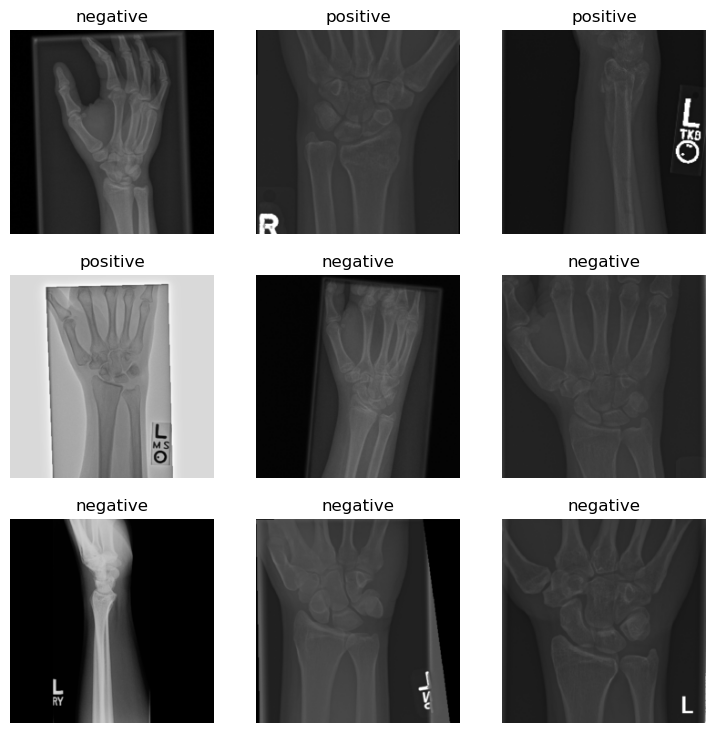

In [23]:
dls.show_batch()

# Train a model

In [24]:
import timm

In [25]:
#timm.list_models("*convnext*")

In [26]:
model = 'convnext_tiny_in22ft1k'

In [27]:
learn = vision_learner(dls, model, metrics=accuracy, model_dir="/kaggle/working/models")

Downloading: "https://dl.fbaipublicfiles.com/convnext/convnext_tiny_22k_1k_224.pth" to /root/.cache/torch/hub/checkpoints/convnext_tiny_22k_1k_224.pth


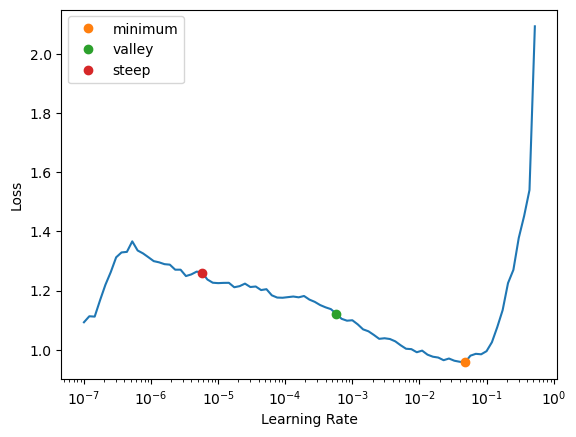

In [28]:
lr = learn.lr_find(suggest_funcs=(minimum, valley, steep))

In [29]:
lr_max = (lr.steep + lr.valley)/2
print(lr_max)

0.00029059717280688346


In [30]:
learn.fit_one_cycle(4, slice(lr_max))

epoch,train_loss,valid_loss,accuracy,time
0,0.722264,0.500155,0.807284,02:14
1,0.604514,0.460168,0.825493,01:57
2,0.513298,0.440948,0.827011,01:55
3,0.500434,0.440036,0.827011,01:57


# Evaluate model

In [31]:
interp = ClassificationInterpretation.from_learner(learn)

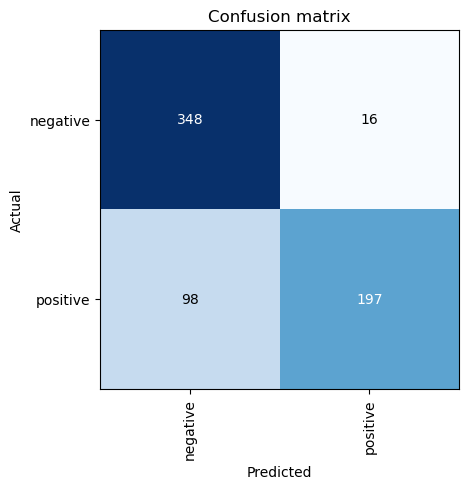

In [32]:
interp.plot_confusion_matrix()

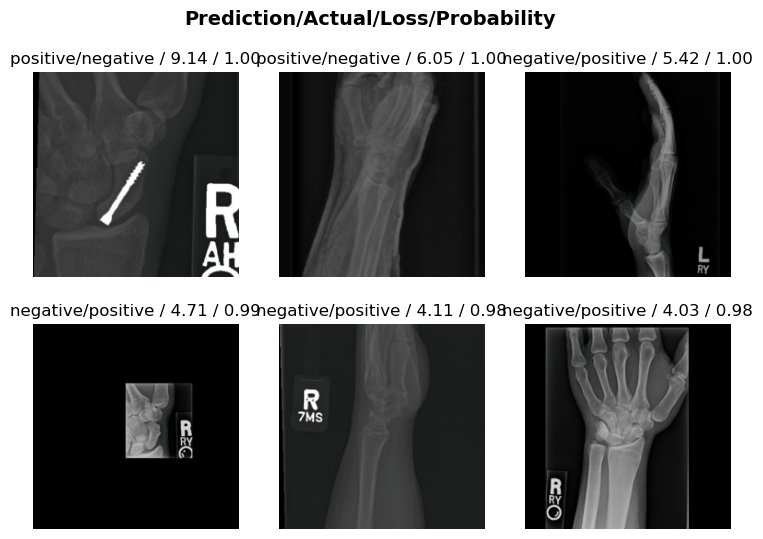

In [33]:
interp.plot_top_losses(6)

# Export the model

In [34]:
learn.export('/kaggle/working/models/mura_model.pkl')

# FGSM attack

> See the notebook [asl-1-0-adversarial-dogs-vs-cats](https://www.kaggle.com/alexanderlundervold/dat255-1-0-adversarial-dogs-vs-cats) for more details.

In [35]:
learn.training

False

In [36]:
learn = load_learner('/kaggle/working/models/mura_model.pkl')

In [37]:
df.loc[df.is_valid==True].head()

,study,is_valid,label,subject_id,bodypart
0,MURA-v1.1/valid/XR_WRIST/patient11185/study1_positive/image1.png,True,positive,11185,XR_WRIST
1,MURA-v1.1/valid/XR_WRIST/patient11185/study1_positive/image2.png,True,positive,11185,XR_WRIST
2,MURA-v1.1/valid/XR_WRIST/patient11185/study1_positive/image3.png,True,positive,11185,XR_WRIST
3,MURA-v1.1/valid/XR_WRIST/patient11185/study1_positive/image4.png,True,positive,11185,XR_WRIST
4,MURA-v1.1/valid/XR_WRIST/patient11186/study1_positive/image1.png,True,positive,11186,XR_WRIST


In [38]:
import torchvision.transforms as T

In [39]:
def fgsm_attack(image, epsilon, image_grad):
    # Collect the element-wise sign of the image gradient
    sign_image_grad = image_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_image_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

In [40]:
def perturb(learn, img_path, epsilon):

    # Perform the transformations and instruct PyTorch to track the gradients
    img_t = T.ToTensor()(PILImage.create(img_path).resize((sz,sz)))
    img_t = img_t.requires_grad_(True)

    output = learn.model(img_t[None])

    # Here's the prediction before the attack
    predicted_label = torch.argmax(output)

    # Perform the attack
    loss = learn.loss_func(output, predicted_label)
    learn.zero_grad()
    loss.backward()
    img_t_grad = img_t.grad.data
    perturbed_image = fgsm_attack(img_t, epsilon, img_t_grad)

    # Here's the prediction after the attack
    perturbed_output = learn.model(perturbed_image[None])
    perturbed_label = torch.argmax(perturbed_output)

    # We need to convert the image back to numpy for plotting
    perturbed_image = perturbed_image.detach().cpu().permute(1, 2, 0).numpy()

    return perturbed_image, learn.dls.vocab[predicted_label], learn.dls.vocab[perturbed_label]


In [41]:
def show_perturbed_img(original_image, predicted_label, perturbed_image, perturbed_label, epsilon):

    f, ax = plt.subplots(1,2, figsize=(10,10))

    ax[0].imshow(PILImage.create(original_image).resize((sz,sz)))
    ax[0].axis('off')
    ax[0].set_title(f"Original image. Label: {predicted_label}")

    ax[1].imshow(perturbed_image)
    ax[1].axis('off')
    ax[1].set_title(f"Perturbed image. Label: {perturbed_label}; Epsilon: {epsilon}")

    plt.show()

In [42]:
epsilon=0.002

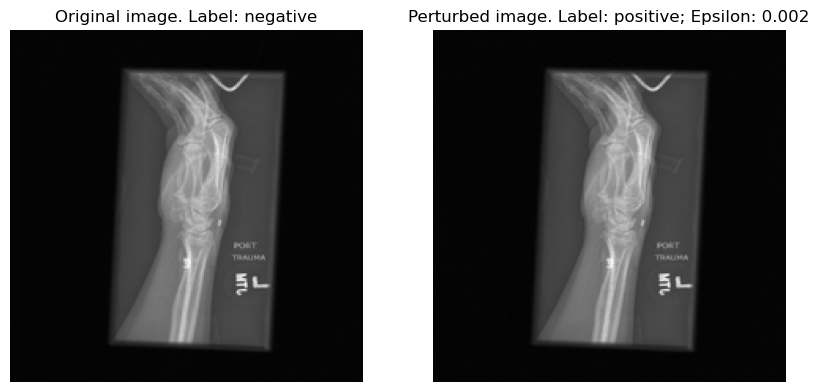

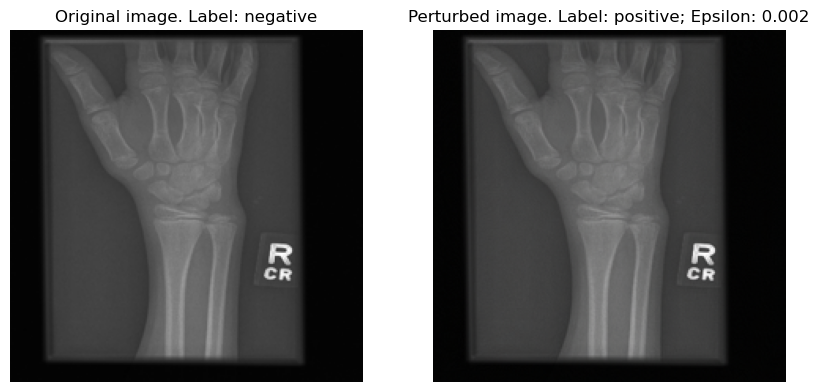

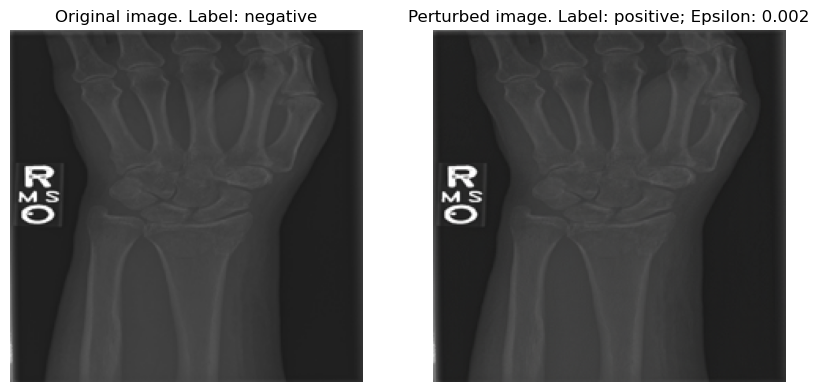

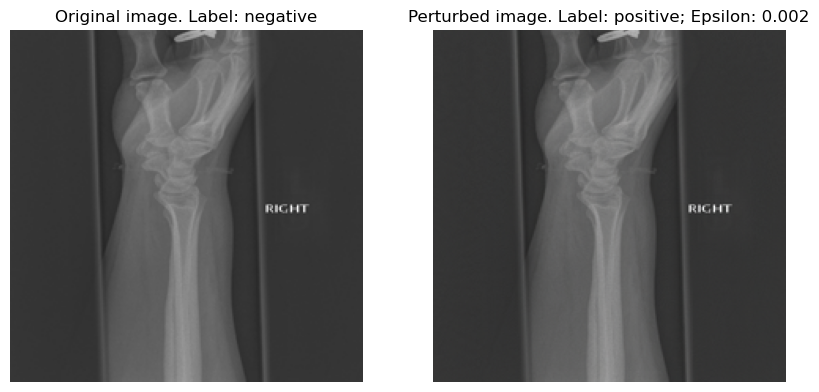

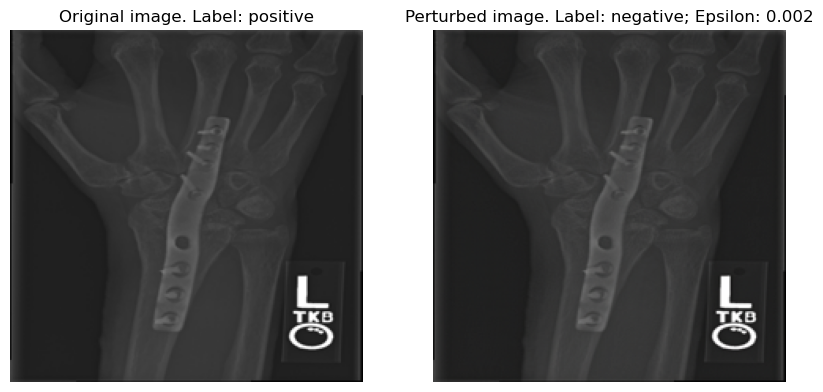

In [44]:
for test_img in random.choices(df.loc[df.is_valid==True].study, k=5):
    test_img = DATA/test_img
    perturbed_image, predicted_label, perturbed_label = perturb(learn, test_img, epsilon)
    show_perturbed_img(test_img, predicted_label, perturbed_image, perturbed_label, epsilon=epsilon)